In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

# Introduction to Hidden Markov Models(HMMs)
**HMMs** have been widely used in **Natural Language Processing(NLP)**, such as[1]
- Speech Recognition
- Morphological Analysis
- Part of Speech Tagging (PoST)
- Text Classification

The HMMs is based on augmenting the **Markov chain**. A Markov chain is a model that tells us something about the probabilities of sequences of random variables, states, each of which can take on values from some set. These sets can be words, tags, or symbols representing anything in NLP.

## Markov Models
**Markov Assumption:** Consider a sequence of state variables $x_1, x_2,...,x_n$. Markov assumption on the probabilities of this sequence is that when predicting the future, the past doesn’t matter, only the present.

$$
p (x_i = s_j| x_1, x_2, ..., x_{i-1}) = p (x_i | x_{i-1})\\
$$

Let's get into a simple example. The Markov Model is used to predict the weather of tomorrow using previous information of the past days.

In [2]:
from graphviz import Digraph
dot = Digraph(comment='The Round Table')
dot.node('S1', 'Sunny')
dot.node('S2', 'Rainy')
dot.node('S3', 'Cloudy')

#dot.edges(['AB', 'AL'])
#dot.edge('B', 'L', constraint='false',label="0.5")
dot.edge('S1', 'S1', constraint='false', label="0.8")
dot.edge('S1', 'S2', constraint='false', label="0.05")
dot.edge('S1', 'S3', constraint='false', label="0.15")
dot.edge('S2', 'S1', label="0.2")
dot.edge('S2', 'S2', label="0.6")
dot.edge('S2', 'S3', label="0.2")
dot.edge('S3', 'S1', constraint='false', label="0.2")
dot.edge('S3', 'S2', constraint='false', label="0.3")
dot.edge('S3', 'S3', constraint='false', label="0.5")

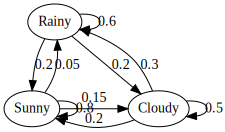

In [3]:
dot

Our model has only 3 states: $S = \{s_1, s_2, s_3\}$, and the name of each state is $s_1$ = Sunny, $s_2$ = Rainy, $s_3$ = Cloudy.

### Example 1:
Assuming yesterday’s weather was Rainy, and today is Cloudy. What is the probability that tomorrow will be Sunny?

The answer is 0.2.

$P(Sunny|Cloudy) = P(x_3|x_2) = P(x_3|x_1, x_2)$

### Example 2:
Given that today is Sunny, what’s the probability that tomorrow is Sunny and the next day Rainy?

The answer is $0.04$.

$0.8*0.05 = P(Sunny|Sunny)P(Rainy|Sunny) = P(x_2|x_1)P(x_3|x_2) = P(x_2|x_1)P(x_3|x_1, x_2) = P(x_2, x_3|x_1)$

A Markov chain is specified by the following components:
- $S = \{s_{1}, s_{2}, ..., s_{n}\}$: A set od N states
- The $n \times n$ matrix **$W_{ij} = P (x_i | x_j)$** which is defined for a state space with n states, is called **Transition Probability matrix**. It specifies the Markov process.

Therefore, the **Transition Probability matrix** from the abrove example can be written as
$$
  W =
  {\begin{bmatrix}
   0.8 & 0.2 & 0.2\\
   0.05 & 0.6 & 0.3\\
   0.15 & 0.2 & 0.5\\
  \end{bmatrix} }
$$

- If $\pi$ shows a vector of the probability of initial states such as $\pi = [\pi_{x_1}, \pi_{x_2}, ... , \pi_{x_n}]^T$ therefore, since the Markov process is **memoryless**, after $n+1$ cycle we will get the following results:

$$
\pi^{(n+1)} = W \pi^{(n)} = W^n \pi^{(1)}
$$

and after enough cycles:

$$
\pi^{(\infty)} = W \pi^{(\infty)}
$$

It means that it forgets where it started from. We call that $\pi^{\infty}$  the **Stationary Distribution**. It is actually the **eigenvector of W corresponding to eigenvalue 1**[3].

In [4]:
# create state space and initial state probabilities
states = np.array(['Chore', 'Take Care of the baby', 'Relax'])   # State Array  
pi = np.array([0.3, 0.5, 0.2])                                  # Initial Probability
state_space = pd.Series(pi, index=states, name='states')
print state_space
print "\nSum of pi = ", np.sum(pi)

Chore                    0.3
Take Care of the baby    0.5
Relax                    0.2
Name: states, dtype: float64

Sum of pi =  1.0


In [5]:
# create transition probability matrix
fstCol = np.array([0.30, 0.45, 0.25])        # the probability from the state 1 to j
secCol = np.array([0.30, 0.45, 0.25])        # the probability from the state 2 to j
tirCol = np.array([0.30, 0.50, 0.20])        # the probability from the state 3 to j
MC_df = pd.DataFrame(columns=states, index=states)
MC_df.loc[states[0]] = fstCol
MC_df.loc[states[1]] = secCol
MC_df.loc[states[2]] = tirCol

print "Markov Chain is"
print MC_df

MC = MC_df.values
print "\n Transition Probability Matrix (TPM) is\n",
TPM = np.zeros((3, 3))
TPM[:, 0] = fstCol.copy()
TPM[:, 1] = secCol.copy()
TPM[:, 2] = tirCol.copy()
print(TPM)

print "\nSum all elements of Row:"
print np.sum(TPM, axis=0)                    # axis = 0: sum of column

Markov Chain is
                      Chore Take Care of the baby Relax
Chore                   0.3                  0.45  0.25
Take Care of the baby   0.3                  0.45  0.25
Relax                   0.3                   0.5   0.2

 Transition Probability Matrix (TPM) is
[[0.3  0.3  0.3 ]
 [0.45 0.45 0.5 ]
 [0.25 0.25 0.2 ]]

Sum all elements of Row:
[1. 1. 1.]


In [7]:
eigVal, eigVec = np.linalg.eig(TPM)
normVec = np.abs(eigVec[:, 0]) / np.linalg.norm(eigVec[:, 0], 1)
print "Stationary Distribution = ", normVec

Stationary Distribution =  [0.3        0.46190476 0.23809524]


## What Is Hidden Markov Models (HMMs)
So far we heard of the Markov assumption and Markov models. So, what is a Hidden Markov Models? Well, suppose you were locked in a room for several days, and you were asked about the weather outside. The only information you have is whether the person who comes into the room bringing your daily meal is carrying an umbrella or not.

|Weather| Umbrella| No umberlla|
|--|--|--|
|Sunny| 0.1| 0.9|
|Rainy| 0.8| 0.2|
|coludy| 0.3| 0.7|

### Three canonical problems to solve with HMMs:
- **What is the probability that the observed sequence came from the model?**
- **Given the observation sequence, what is the most likely sequence of hidden model states?**
- **How do we train the model given a set of observations?**

### Emission Probability Matrix
It gets a little more interesting. Now we create the **Emission Probability matrix**. This emission probability matrix is size $m \times k$  matrix where $k$ is the number of possible observable states and $m$ the is number of hidden states.

Let's keep the same observable states from the previous example.
### Example 3
Consider problem 2. Given the observation sequence "No umberlla", "No umberlla", "No umberlla". What is the most likely sequence of hidden model states? Find state sequence which maximizes probability of observation sequence.
Suppose you do not know how the weather was when your were locked in. The following three days the caretaker always comes without an umbrella. 

Calculate what is the most likely weather sequence?

|Weather| Sunny| Rainy| Cloudy|
|--|--|--|--|
|Sunny| 0.8| 0.05| 0.15| 
|Rainy| 0.2| 0.6| 0.2|
|Cloudy| 0.2| 0.3| 0.5|

The answer is $max\{P(SSS|NNN),P(SSR|NNN), \ldots, P(CCC|NNN) \}$

Where, $P(SSS|NNN) = 0.3*0.9*0.8*0.9*0.8*0.9=0.139968$

Let's assume that $n$ days had passed. therefore, we will have an observation sequence $O = \{ o_1, o_2, \ldots, o_n \}$, where $o_i \in \{ Unbrella, No unbrella \}$.

Each observation comes from an unknown state. Therefore, we will alos have an unknown dequence $Q = \{ q_1, q_2, \ldots, q_n\}$, where $q_i \in \{Sunny, Rainy, Cloudy \}$

We would like to know: $arg max \{ \prod_{i=1}^{n} P(q_i|q_{i-1})P(o_i|q_i) \}$, where $P(q_1, q_2, \ldots, q_n|o_1, o_2, \ldots, o_n ) = \prod_{i=1}^{n} P(q_i|q_{i-1})P(o_i|q_i)$

Therefore, the computational cost is $O(m^n)$. $m = $ number of hidden states in the model.

### Viterbi Algorithm

The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states, especially in the context of Markov information sources and hidden Markov models[5].

1. Initialize $\delta_0(Q) = 1$ for the start state, and $\delta_n(Q) = 0$ for all other states.
2. For each value $i = 1, \ldots, n$, calculate:

(a) $\delta_i(o) = max(P(q_i|q_{i-1})P(o_{i-1}|q_{i-1})\delta_{i-1}(o_{i-1}))$.

(b) $\psi_i = argmax (P(q_i|q_{i-1})P(o_{i-1}|q_{i-1})\delta_{i-1}(o_{i-1}))$

Therefore, the computational cost is $O(m^2 n)$. $m = $ number of hidden states in the model.

In [8]:
hidden_states = np.array(['Exhausted', 'Not tired'])
hidden_pi = np.array([0.5, 0.5])
h_state_space = pd.Series(hidden_pi, index=hidden_states, name='states')
print h_state_space 
print "\nSum of pi (Initial hidden state) = ", np.sum(h_state_space)

Exhausted    0.5
Not tired    0.5
Name: states, dtype: float64

Sum of pi (Initial hidden state) =  1.0


In [9]:
# create hidden transition matrix
h_fstCol = np.array([0.70, 0.30])        # the probability from the state 1 to j
h_secCol = np.array([0.60, 0.40])        # the probability from the state 2 to j

hMC_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
hMC_df.loc[hidden_states[0]] = h_fstCol
hMC_df.loc[hidden_states[1]] = h_secCol

print hMC_df

hMC = hMC_df.values
print "hMC", hMC

print "\n Transition Probability Matrix (TPM) is",
h_TPM = np.zeros((2, 2))
h_TPM[:, 0] = h_fstCol.copy()
h_TPM[:, 1] = h_secCol.copy()
#TPM[:, 2] = tirCol.copy()
print "\n", h_TPM

print "\nSum all elements of Rows :"
print np.sum(h_TPM, axis=0)                    # axis = 0: sum of row

          Exhausted Not tired
Exhausted       0.7       0.3
Not tired       0.6       0.4
hMC [[0.7 0.3]
 [0.6 0.4]]

 Transition Probability Matrix (TPM) is 
[[0.7 0.6]
 [0.3 0.4]]

Sum all elements of Rows :
[1. 1.]


In [10]:
# create matrix of observation (emission) probabilities
observable_states = states

e_fstCol = np.array([0.2, 0.5, 0.3])        # the probability from the state 1 to j
e_secCol = np.array([0.3, 0.5, 0.2])        # the probability from the state 2 to j

#e_fstCol = np.array([0.1, 0.5, 0.4])        # the probability from the state 1 to j
#e_secCol = np.array([0.3, 0.5, 0.2])        # the probability from the state 2 to j

em_df = pd.DataFrame(columns=observable_states, index=hidden_states)
em_df.loc[hidden_states[0]] = e_fstCol
em_df.loc[hidden_states[1]] = e_secCol

print em_df

em = em_df.values
print "em = ", em

print "\nEmission Matrix (EM) is",
EM = np.zeros((3, 2))
EM[:, 0] = e_fstCol.copy()
EM[:, 1] = e_secCol.copy()

print "\n", EM

print "\nSum of all each of row :"
print np.sum(EM, axis=0)                    # axis = 0: sum of row

          Chore Take Care of the baby Relax
Exhausted   0.2                   0.5   0.3
Not tired   0.3                   0.5   0.2
em =  [[0.2 0.5 0.3]
 [0.3 0.5 0.2]]

Emission Matrix (EM) is 
[[0.2 0.3]
 [0.5 0.5]
 [0.3 0.2]]

Sum of all each of row :
[1. 1.]


In [11]:
# observation sequence
obs_map = {'Chore':0, 'Take Care of the baby':1, 'Relax':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq'])

   Obs_code                Obs_seq
0         1  Take Care of the baby
1         1  Take Care of the baby
2         2                  Relax
3         1  Take Care of the baby
4         0                  Chore
5         1  Take Care of the baby
6         2                  Relax
7         1  Take Care of the baby
8         0                  Chore
9         2                  Relax
10        2                  Relax
11        0                  Chore
12        1  Take Care of the baby
13        0                  Chore
14        1  Take Care of the baby


In [12]:
# define Viterbi algorithm for shortest path
def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    print "No. of hidden States", nStates
    T = np.shape(obs)[0]
    print "No. fo sequence states: ", T
    
    # init blank path
    path = np.zeros(T)
    #print "path", path
    delta = np.zeros((nStates, T))
    #print "delta = ", delta
    phi = np.zeros((nStates, T))
        
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    #print "pi = ", pi
    #print "b = ", b
    #print "delta[:, 0] = ", delta[:, 0]
    
    phi[:, 0] = 0
 
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            #print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]) , int(t+1)]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        #print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(hidden_pi, hMC, em, obs)
print "single best state path:"
print path
print "delta:"
print delta
print "phi:"
print phi

No. of hidden States 2
No. fo sequence states:  15
pi =  [0.5 0.5]
b =  [[0.2 0.5 0.3]
 [0.3 0.5 0.2]]
delta[:, 0] =  [0.25 0.25]
--------------------------------------------------
single best state path:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
delta:
[[2.50000000e-01 8.75000000e-02 1.83750000e-02 6.43125000e-03
  9.00375000e-04 3.15131250e-04 6.61775625e-05 2.31621469e-05
  3.24270056e-06 6.80967118e-07 1.43003095e-07 2.00204333e-08
  7.00715165e-09 9.81001230e-10 3.43350431e-10]
 [2.50000000e-01 5.00000000e-02 5.25000000e-03 2.75625000e-03
  5.78812500e-04 1.35056250e-04 1.89078750e-05 9.92663437e-06
  2.08459322e-06 1.94562034e-07 4.08580271e-08 1.28702785e-08
  3.00306499e-09 6.30643648e-10 1.47150185e-10]]
phi:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
state_map = {0:'Exhausted', 1:'Not tire'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,Take Care of the baby,Exhausted
1,Take Care of the baby,Exhausted
2,Relax,Exhausted
3,Take Care of the baby,Exhausted
4,Chore,Exhausted
5,Take Care of the baby,Exhausted
6,Relax,Exhausted
7,Take Care of the baby,Exhausted
8,Chore,Exhausted
9,Relax,Exhausted


# Summary
**The Viterbi algorithm is used for finding the most likely sequence of hidden (latent) states of a sequence of observation.**

# References
1. D. Suleiman, A. Awajana, and W. A. Etaiwi. "The Use of Hidden Markov Model in Natural ARABIC Language Processing: a survey". Procdia Computer Science. 113 (2017): 240–247.
2. L. R. Rabiner and B. H. Juang. "An Introduction to Hidden Markon Models". *IEEE ASPS Magazine*. 3(1986): 4-14.
3. M, Sadeghi. "Bayesian inference in NLP". Florida State University. 2018.
4. https://en.wikipedia.org/wiki/Hidden_Markov_model
5. https://en.wikipedia.org/wiki/Viterbi_algorithm
6. D. Jurafsky and J. H. Martin. "Speech and Language Processing". Prentice Hall, 2008.